This notebook is for checking the performance of the best model - 3 CNN + Max Pooling model on a different set of training and test images. This is Run 2.  

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
batch_size = 32
img_height = 224
img_width = 224

In [3]:
data_dir = "../input/cell-images-for-detecting-malaria/cell_images/cell_images" 
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.25,
  subset="training",
  seed=223,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 27558 files belonging to 2 classes.
Using 20669 files for training.


In [4]:
class_names = train_ds.class_names
print(class_names)


['Parasitized', 'Uninfected']


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.25,
  subset="validation",
  seed=223,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 27558 files belonging to 2 classes.
Using 6889 files for validation.


In [6]:
def get_class(val, dictionary):
    for key,values in dictionary.items():
        if val == values:
            return key
    return

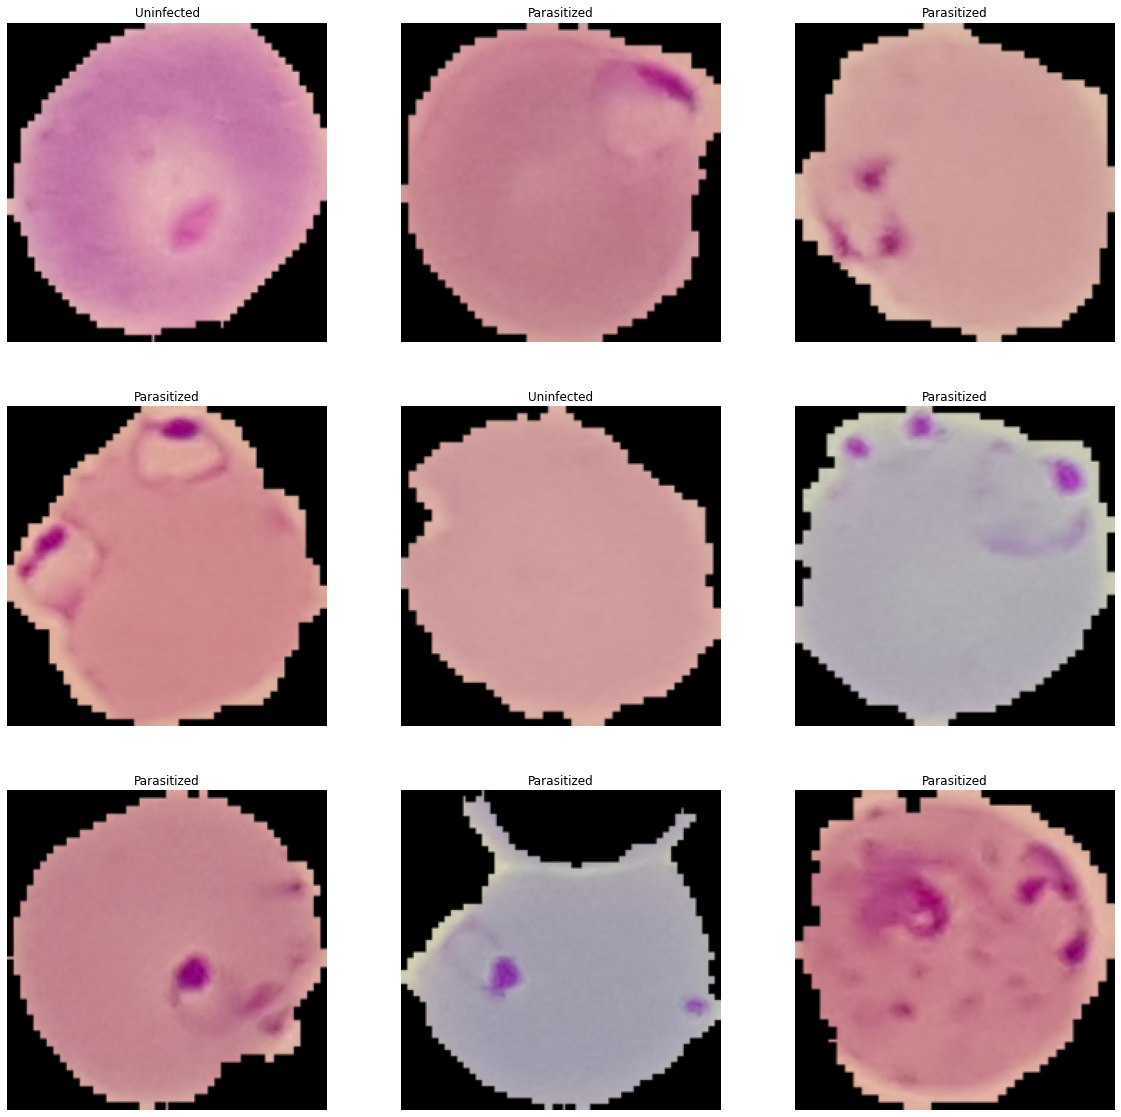

In [7]:
## visualize train set images
image_batch, label_batch = next(iter(train_ds))
plt.figure(figsize=(20, 20))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    name = class_names[label]
    plt.title(name)
    plt.axis("off")

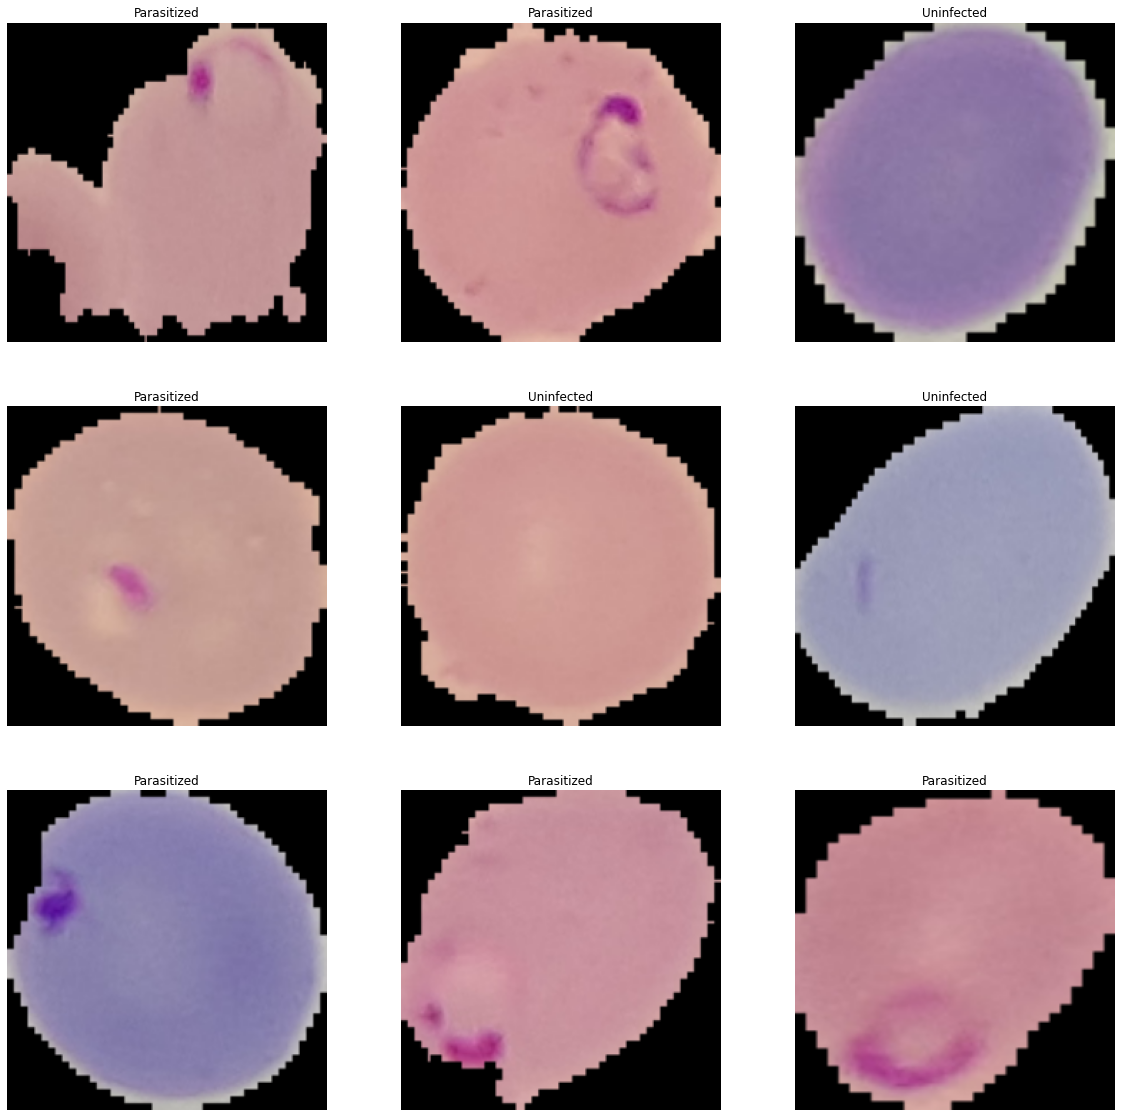

In [8]:
## visualize validation images 
image_batch, label_batch = next(iter(val_ds))
plt.figure(figsize=(20, 20))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    name = class_names[label]
    plt.title(name)
    plt.axis("off")


In [9]:
## train image data set , convert into array .


train_labels = np.array([])
train_images = []
i = 0

for x, y in train_ds:
    n = x.shape[0]
    train_labels = np.concatenate([train_labels , y.numpy()])
    for j in range(n):
            train_images.append(x[j].numpy().astype("uint8"))
train_images = np.array(train_images)


In [10]:
train_images.shape

(20669, 224, 224, 3)

In [11]:
train_labels.shape

(20669,)

CPU times: user 51 s, sys: 6.03 s, total: 57.1 s
Wall time: 52.3 s
216/216 [==============================] - 44s 197ms/step - loss: 0.2788 - accuracy: 0.9406
Test image accuracy :0.9406300187110901
Classification Report
              precision    recall  f1-score   support

 Parasitized       0.97      0.91      0.94      3475
  Uninfected       0.91      0.98      0.94      3414

    accuracy                           0.94      6889
   macro avg       0.94      0.94      0.94      6889
weighted avg       0.94      0.94      0.94      6889

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 4)       112       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 

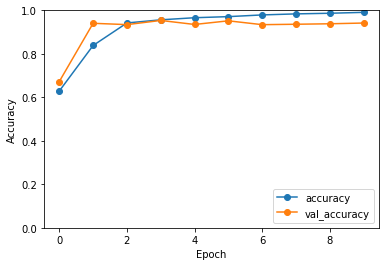

In [12]:
## three layer CNN with fewer filters and dropout layer

##
model = tf.keras.models.Sequential([
     tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D( activation='relu', input_shape=(224, 224, 3), filters = 4, kernel_size = 3),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2, 2)), 
    tf.keras.layers.Conv2D( activation='relu', input_shape=(224, 224, 3), filters = 6, kernel_size = 3),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2, 2)), 
    tf.keras.layers.Conv2D( activation='relu', input_shape=(224, 224, 3), filters = 10, kernel_size = 3),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2, 2)), 
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.BatchNormalization(),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation=tf.nn.relu),
tf.keras.layers.Dense(2, activation=tf.nn.softmax)])


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'], )
%time history = model.fit(train_images,train_labels,  epochs=10, validation_split = 0.2 , verbose = 0)
##
test_loss, test_acc = model.evaluate(val_ds)
print("Test image accuracy :{}".format(test_acc))
##
plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
##
model.save('model_cnn3')
##
## for test data set , check the classification report.
test_pred = np.array([])
test_labels = np.array([])
for x, y in val_ds:
    predictions =  np.argmax(model.predict(x), axis = -1)
    test_pred = np.concatenate([test_pred,np.array(predictions)])
    test_labels = np.concatenate([test_labels , y.numpy()])
    
##
print('Classification Report')
target_names = class_names
print(classification_report(test_labels, test_pred, target_names=class_names))
##
print(model.summary())
##
print("Confusion matrix :\n")
print(confusion_matrix(test_labels, test_pred))

Accuracy is 0.94. Recall of parasitised class is slightly lower at 0.91 with this split of training and test images. 